In [147]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from scipy import constants                     # For scientific constants
from skimage.restoration import unwrap_phase    # unwrap phase
from matplotlib import pyplot as plt
from scipy.optimize import minimize, basinhopping, dual_annealing

Link to ubermag page for this micromagnetic state
https://hub.mybinder.turing.ac.uk/user/ubermag-oommfc-qc70qdxt/notebooks/docs/ipynb/07-tutorial-standard-problem3.ipynb

In [120]:
# Function for initialising the vortex state.
def m_init_vortex(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = np.sin(np.pi/2 * (x-0.5))
    mz = np.cos(np.pi/2 * (x-0.5))
    
    return (mx, my, mz)

# minimise energy of initial state
def minimise_system_energy(L, m_init):
    #print("L={:7}, {} ".format(L, m_init.__name__), end="")
    N = 16  # discretisation in one dimension
    cubesize = 100e-9  # cube edge length (m)
    cellsize = cubesize/N  # discretisation in all three dimensions.
    lex = cubesize/L  # exchange length.
    
    Km = 1e6  # magnetostatic energy density (J/m**3)
    Ms = np.sqrt(2*Km/mm.consts.mu0)  # magnetisation saturation (A/m)
    A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2  # exchange energy constant
    K = 0.1*Km  # Uniaxial anisotropy constant
    u = (0, 1, 0)  # Uniaxial anisotropy easy-axis

    p1 = (0, 0, 0)  # Minimum sample coordinate.
    p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
    cell = (cellsize, cellsize, cellsize)  # Discretisation.
    mesh = df.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
                   cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

    system = mm.System(name='stdprob3')
    print(L)
    system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()
    system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

    md = oc.MinDriver()
    md.drive(system, overwrite=True)
    
    return system

# e- wavelength by voltage
def λ_func(V):
    V *= constants.kilo
    λ = constants.h/(constants.nano*np.sqrt(2*V*constants.m_e*constants.e))
    λ *= 1/(np.sqrt(1+(constants.e*V)/(2*constants.m_e*constants.c**2)))
    return λ

# magnetic phase change
def B_phase_calc(MXr,MYr,MZr,ds = 0.1,kx = 0.1,ky = 0.1,kv = 300,Cs = 8000,Msat = 480767.832897,x_res =6.25,y_res=6.25,z_res=6.25):

    #ds # Defocus step in mm
    #kx # Tikhonov filter radius in x in pixels
    #ky # Tikhonov filter radius in y in pixels
    #kv # Acceleratig voltage of electrons in kV
    #Cs # Spherical aberration coefficient in mm
#     with HiddenPrints():
#         x_res, y_res, z_res, x_size, y_size, z_size, x_begin, y_begin, z_begin, x_end, y_end, z_end = unify_input(X,Y,Z,MXr,MYr,MZr)
    x_size,y_size,z_size = np.shape(MXr)
    
    MXpad = np.pad(MXr,[(100,100),(100,100),(100,100)], mode='constant', constant_values=0)
    MYpad = np.pad(MYr,[(100,100),(100,100),(100,100)], mode='constant', constant_values=0)
    
    ave_m_x = np.mean(MXpad,axis = 2)* Msat
    ave_m_y = np.mean(MYpad,axis = 2)* Msat
    

    
    sx = 1/(x_size*x_res) # sampling in reciprocal space 
    sy = 1/(y_size*y_res) # identical in both directions
    const = 1j/(2*constants.codata.value('mag. flux quantum')/((constants.nano)**2))
    λ = λ_func(kv) # Wavelength of electrons in nm

    ft_mx = np.fft.fft2(ave_m_x*z_size)# , axes=(-2, -1))
    ft_my = np.fft.fft2(ave_m_y*z_size)#, axes=(-2, -1))

    FreqCompRows = np.fft.fftfreq(ft_mx.shape[0],d=x_res)
    FreqCompCols = np.fft.fftfreq(ft_mx.shape[1],d=y_res)
    Xft, Yft = np.meshgrid(FreqCompCols,FreqCompRows, indexing='ij') # Create a grid of coordinates

    nume =  ((Xft**2)+(Yft**2))
    dnom =  ((Xft**2)+(Yft**2)+(sx**2)*(kx**2)+(sy**2)*(ky**2))**2
    cross = -ft_my*Xft+ft_mx*Yft
    B0 = 4*np.pi*1e-7 # * size_n
    ft_phase = np.array(const*cross*nume/dnom) * B0
    phase_B = np.fft.ifft2(ft_phase).real
    
    return phase_B[100:-100,100:-100]

# extract magnetisation
def system_to_mag(system):
    ms = system.m.array

    xs,ys,zs,mx,my,mz = [],[],[],[],[],[]
    for i in range(16):
        for j in range(16):
            for k in range(16):
                xs.append(i)
                ys.append(j)
                zs.append(k)
                mx.append(ms[i][j][k][0])
                my.append(ms[i][j][k][1])
                mz.append(ms[i][j][k][2])
    Mx,My,Mz = np.reshape(mx,(16,16,16)),np.reshape(my,(16,16,16)),np.reshape(mz,(16,16,16))
    return Mx,My,Mz

# calculate phase from initial micromagnetic parameter
def phase_guess(L):
    system = minimise_system_energy(L, m_init_vortex)
    MX,My,Mz = system_to_mag(system)
    phase_B = B_phase_calc(Mx,My,Mz)
    pu = unwrap_phase(phase_B)
    
    return pu

L=      8, m_init_vortex Running OOMMF (TclOOMMFRunner) [2021/02/01 15:51]... (14.2 s)


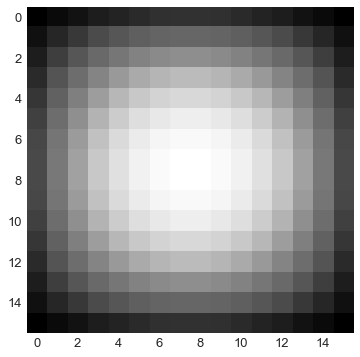

In [84]:
# Generate True Phase Reference
system = minimise_system_energy(8, m_init_vortex)
MX,My,Mz = system_to_mag(system)
phase_B = B_phase_calc(Mx,My,Mz)
pu = unwrap_phase(phase_B)
plt.imshow(pu,cmap='Greys')

np.save('true_vortex_phase.npy',pu)
true_phase = np.load('true_vortex_phase.npy')

# view magnetisation
#M_proj = np.hypot(np.mean(Mx,axis=2),np.mean(My,axis=2)).T
#plt.imshow(M_proj,cmap='Blues')
#system.m.plane('z').mpl()

Text(0.5, 1.0, 'True Magnetisation')

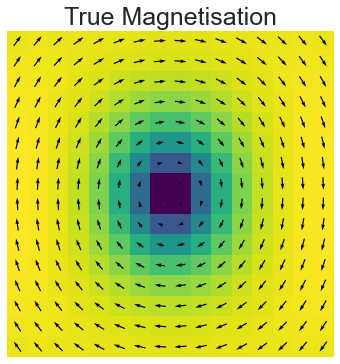

In [219]:
M_proj = np.hypot(np.mean(Mx,axis=2),np.mean(My,axis=2)).T
plt.imshow(M_proj,cmap='viridis')
plt.quiver(np.mean(Mx,axis=2)[::-1].T,np.mean(My,axis=2)[::-1].T,pivot='middle')
plt.axis('off')
plt.title('True Magnetisation',fontsize=25)

In [130]:
# Function to calculate Chi^2  

def chi2_distance(L): 
    A = true_phase
    B = phase_guess(L[0])
    
    all_L.append(L[0])
    # compute the chi-squared distance using above formula 
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)  
                      for (a, b) in zip(A, B)]) 
    
    all_chi.append(abs(chi))
    print(abs(chi))
  
    return abs(chi)

In [151]:
# Optimisation stage 1 - find region of global min
all_L = []
all_chi = []
x0 = [6]
minimizer_kwargs = {"method": "L-BFGS-B","tol":1}
res = dual_annealing(chi2_distance, [(5,11)], maxiter=5, local_search_options=minimizer_kwargs,x0=x0)

6
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:23]... (11.4 s)
2340636.587167696
9.24629501439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:23]... (12.3 s)
1425.5961520943151
7.485351849347353
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:24]... (12.3 s)
2208127.1072542313
9.24629501439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:24]... (11.5 s)
1425.5961520943151
9.24629502439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:24]... (11.5 s)
1425.5961670026797
8.24629501439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:24]... (13.1 s)
106.42426238236465
8.24629502439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:25]... (12.6 s)
106.42427030454834
6.744755581021309
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:25]... (11.6 s)
2277304.5985024204
9.169160284101963
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:25]... (11.6 s)
1314.795545404223
10.326490555191413
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:25]... (11.9 s)
1127.761701163271
10.256077758967876
Running OOMMF 

In [159]:
# optimisation stage 2 - get more precise final result
all_L = []
all_chi = []
x0 = res.x
res2 = minimize(chi2_distance, x0, method='Nelder-Mead',tol=0.01)

8.24629501439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:31]... (15.0 s)
106.42426238236465
8.658609765116125
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:31]... (16.7 s)
575.2191928056793
7.833980263676494
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:32]... (12.5 s)
64.74830866506328
7.421665512956679
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:32]... (14.8 s)
2214292.355870486
7.421665512956679
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:32]... (14.8 s)
2214292.355870486
8.040137639036402
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:32]... (16.8 s)
3.2713025981189197
8.24629501439631
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:33]... (13.5 s)
106.42426238236465
7.937058951356448
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:33]... (12.4 s)
8.65704899129171
8.143216326716356
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:33]... (14.8 s)
38.700839159881525
7.988598295196425
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:34]... (14.0 s)
0.27385385446926147
7.937058951356448

In [160]:
all_L1 = all_L
all_chi1 = all_chi

In [164]:
all_L = np.concatenate((all_L0,all_L1))
all_chi = np.concatenate((all_chi0,all_chi1))

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

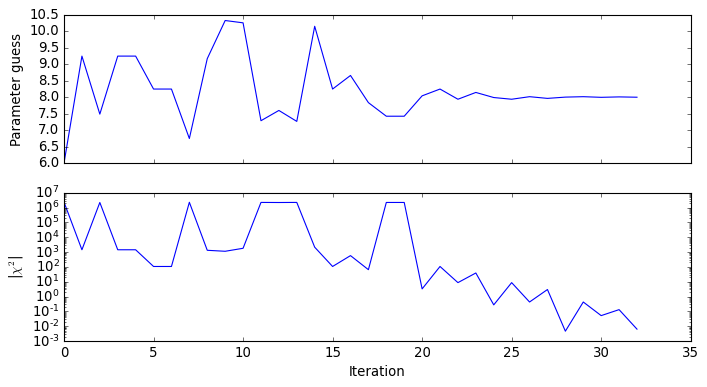

In [236]:
fig= plt.figure(figsize=(9,5))
fig.patch.set_facecolor('w')
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(all_L)
ax2.plot(all_chi)

plt.xlabel('Iteration')
ax1.set_ylabel('Parameter guess')
ax2.set_ylabel('|$\chi^2$|')
ax2.set_yscale('log')
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.set_facecolor('w')
ax2.set_facecolor('w')

plt.tight_layout()
plt.title

In [180]:
final_phase = phase_guess(res2.x[0])

8.00148313115642
Running OOMMF (TclOOMMFRunner) [2021/02/01 17:45]... (14.4 s)


Text(0.5, 1.0, 'Optimised Phase, L = 8.00148')

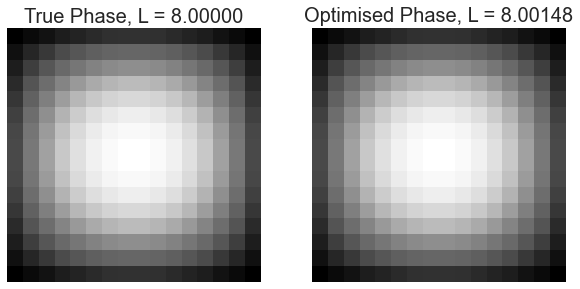

In [197]:
fig= plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(true_phase,cmap='Greys')
ax2.imshow(final_phase,cmap='Greys')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('True Phase, L = %.5f' % 8)
ax2.set_title('Optimised Phase, L = %.5f' % res2.x[0])

In [176]:
len(all_L1),len(all_L)

(18, 33)